In [1]:
import numpy as np 
import pandas as pd 

from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

import warnings
warnings.simplefilter(action='ignore')

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/abdullabasim/dataset/main/bill_authentication.csv")

data.head()

,Variance,Skewness,Curtosis,Entropy,Class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Variance  1372 non-null   float64
 1   Skewness  1372 non-null   float64
 2   Curtosis  1372 non-null   float64
 3   Entropy   1372 non-null   float64
 4   Class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [4]:
data.describe()

,Variance,Skewness,Curtosis,Entropy,Class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


In [5]:
data['Class'].value_counts()

0    762
1    610
Name: Class, dtype: int64

Text(0, 0.5, 'Curtosis')

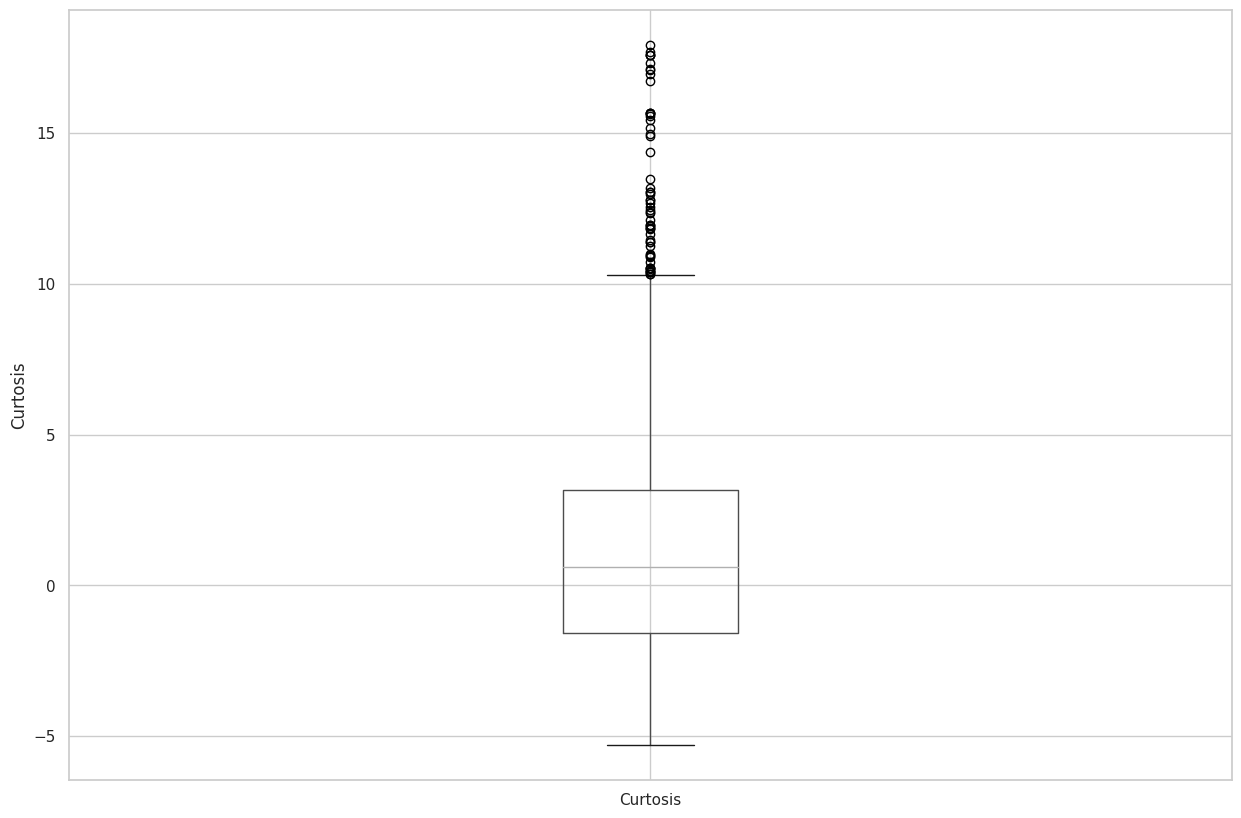

In [6]:
plt.figure(figsize=(15,10))

fig = data.boxplot(column='Curtosis')
fig.set_title('')
fig.set_ylabel('Curtosis')

In [7]:
from sklearn.linear_model import LinearRegression


Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers for each column
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = ((data < lower_bound) | (data > upper_bound)).any(axis=1)

# Impute outliers with linear regression for each column
for col in data.columns:
    reg = LinearRegression()
    X_train = data.loc[~outliers, [c for c in data.columns if c != col]].values
    y_train = data.loc[~outliers, col].values.reshape(-1, 1)
    X_test = data.loc[outliers, [c for c in data.columns if c != col]].values
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    data.loc[outliers, col] = y_pred.flatten()

In [8]:
X = data.drop(['Class'], axis=1)
y = data['Class']
y= data['Class'].astype(str)

In [9]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [10]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [11]:
# Applying Grid Search to find the best model and the best parameters
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier( random_state = 14)

parameters = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search.fit(X_train,y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 92.91 %
Best Parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200}


In [12]:
classifier = RandomForestClassifier(criterion='gini', max_depth=8,max_features ='auto',n_estimators =200 , random_state= 3)

# fit the model
classifier.fit(X_train,y_train)

RandomForestClassifier(max_depth=8, max_features='auto', n_estimators=200,
                       random_state=3)

In [13]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[186   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   3   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   1]
 [  0   0   0 ...   0   0   0]]


0.9212827988338192

In [14]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)

print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 92.81 %
Standard Deviation: 0.65 %
